In [180]:
import pandas as pd
import numpy as np
import sklearn.manifold
from scipy.spatial.distance import cosine
from scipy.stats import entropy
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import seaborn as sns
import umap
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import hdbscan
from sklearn.metrics.pairwise import cosine_distances


## Clustering
# 1. Load data
file_path = 'data/evaluated_compliant_ideas.csv' 
df = pd.read_csv(file_path)

# 2. Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 3. Generate Embeddings
ideas = df['use'].fillna("").tolist()
# ideas = [idea.strip().lower() for idea in ideas]
all_embeddings = model.encode(ideas, show_progress_bar=True)

pd.DataFrame(all_embeddings)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2227.27it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 35/35 [00:00<00:00, 137.22it/s]


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.042616,0.033062,0.012394,-0.008894,0.002593,-0.035735,0.082179,-0.064493,-0.043251,0.042031,...,0.062508,0.022603,0.002096,-0.061622,-0.026033,0.059837,-0.000806,-0.013945,-0.018971,0.080899
1,-0.078420,0.028434,0.038596,0.007725,-0.062924,-0.028573,0.118622,0.050293,-0.006366,0.032477,...,0.079565,-0.035203,0.003263,-0.027090,-0.063735,0.025888,0.064598,0.023326,0.051851,0.086517
2,-0.112569,0.102765,0.070860,-0.002446,-0.019101,-0.049897,0.134271,0.054531,0.050845,-0.006434,...,0.074760,-0.006426,0.046038,0.021690,-0.036403,0.026310,-0.018037,0.026357,-0.014549,0.043539
3,-0.051591,0.091319,-0.109953,-0.053746,0.011242,0.021850,0.160081,0.042298,0.044789,0.029496,...,0.017586,-0.004970,0.064151,-0.032927,0.034996,0.094898,0.012305,0.037371,0.027649,-0.003261
4,-0.038407,0.075182,0.065649,0.009663,0.058841,-0.062329,0.102937,-0.034653,-0.017826,-0.018645,...,-0.029375,0.028598,0.044185,-0.032129,-0.033746,0.020764,0.059112,0.021998,0.020001,0.043812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,-0.075652,0.028117,-0.018058,-0.014307,-0.089418,-0.034747,0.043809,0.022374,-0.126842,-0.072384,...,0.008104,0.050209,0.023312,-0.088109,-0.048438,0.054986,-0.127250,0.107589,-0.010408,-0.008101
1093,-0.037784,-0.012249,0.037365,-0.085891,0.007403,-0.033447,0.133519,-0.024422,-0.078103,0.009721,...,0.019185,0.081368,-0.033183,-0.025955,-0.107175,0.049950,-0.044573,0.017162,0.092473,-0.011938
1094,-0.014247,0.048228,0.058841,-0.018333,0.026537,-0.102838,0.049047,-0.073342,-0.058340,0.040603,...,0.076632,0.026477,0.008941,0.044457,-0.083832,0.078992,-0.059158,-0.009603,0.066672,-0.059270
1095,-0.058346,0.080272,0.015484,-0.020585,0.026904,-0.067640,0.065605,-0.082310,-0.028755,0.056253,...,-0.023689,0.010823,0.002966,-0.029770,0.075965,0.005171,-0.017544,0.051095,-0.020200,0.026109


In [182]:

# 4. Prepare for Clustering
unique_objects = df['object'].unique()
unique_conditions = df['condition'].unique()

# Use HDBSCAN to cluster ideas based on their embeddings
for cond in unique_conditions:
    for obj in unique_objects:
        obj_cond_mask = (df['object'] == obj) & (df['condition'] == cond)
        if obj_cond_mask.sum() < 2:  # Skip if less than 2 samples
            continue
        # Get the 384-dimensional vectors
        raw_vectors = all_embeddings[obj_cond_mask]
        
        # HDBSCAN with 'cosine' metric for raw embeddings
        # min_cluster_size: Adjust this based on total N (e.g., 5-10)
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=7, 
            min_samples=1,
            cluster_selection_epsilon=0, # Adjust this to control cluster granularity
            metric='euclidean', # Note: HDBSCAN works best with euclidean on normalized vectors
            cluster_selection_method='eom'
        )
        
        cluster_labels = clusterer.fit_predict(raw_vectors)
        
        df.loc[obj_cond_mask, 'raw_cluster_label'] = cluster_labels

pd.DataFrame(df)





,submitter_id,condition,object,use,raw_cluster_label
0,R_115s8DzuNY8GZYe,Control,brick,door stopper,4.0
1,R_115s8DzuNY8GZYe,Control,bubblewrap,toy,1.0
2,R_115s8DzuNY8GZYe,Control,bubblewrap,phone case,-1.0
3,R_115s8DzuNY8GZYe,Control,bubblewrap,security system,-1.0
4,R_115s8DzuNY8GZYe,Control,bubblewrap,window cleaner,-1.0
...,...,...,...,...,...
1092,R_7wcOe7LsUrh7hzH,Low-Agency,frisbee,DIY fish feeding station,-1.0
1093,R_7wcOe7LsUrh7hzH,Low-Agency,frisbee,DIY frog pond floatie,-1.0
1094,R_7wcOe7LsUrh7hzH,Low-Agency,frisbee,DIY turtle island,-1.0
1095,R_7wcOe7LsUrh7hzH,Low-Agency,frisbee,DIY bird feeder,-1.0


In [151]:

# Get noise ratios for each condition and object
noise_ratios = df.groupby(['condition', 'object'])['raw_cluster_label'].apply(lambda x: (x == -1).mean())
print("Noise Ratios by Condition and Object:")
print(noise_ratios)

# Number of clusters per condition and object (excluding noise)
num_clusters = df[df['raw_cluster_label'] != -1].groupby(['condition', 'object'])['raw_cluster_label'].nunique()
print("\nNumber of Clusters by Condition and Object (excluding noise):")
print(num_clusters)


Noise Ratios by Condition and Object:
condition    object    
Control      brick         0.000000
             bubblewrap    0.000000
             frisbee       0.631579
High-Agency  brick         0.000000
             bubblewrap    0.000000
             frisbee       0.396040
Low-Agency   brick         0.000000
             bubblewrap    0.000000
             frisbee       0.536000
Name: raw_cluster_label, dtype: float64

Number of Clusters by Condition and Object (excluding noise):
condition    object    
Control      brick         0
             bubblewrap    0
             frisbee       6
High-Agency  brick         0
             bubblewrap    0
             frisbee       3
Low-Agency   brick         0
             bubblewrap    0
             frisbee       4
Name: raw_cluster_label, dtype: int64


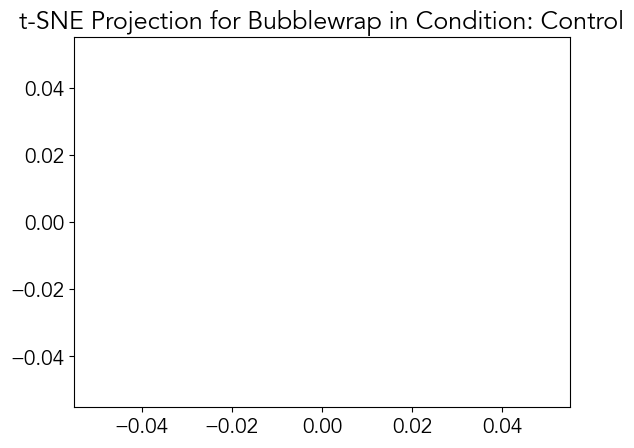

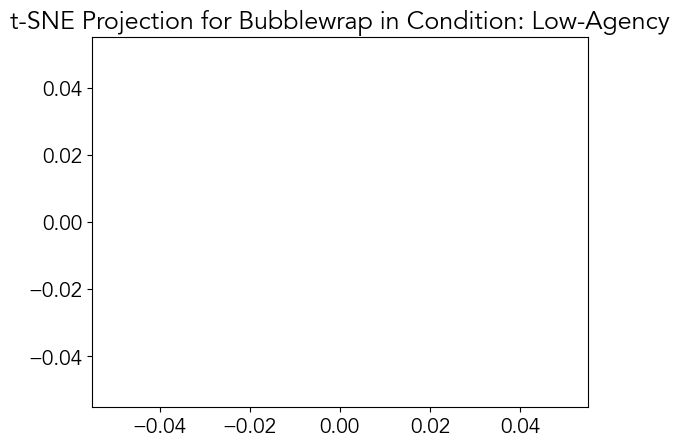

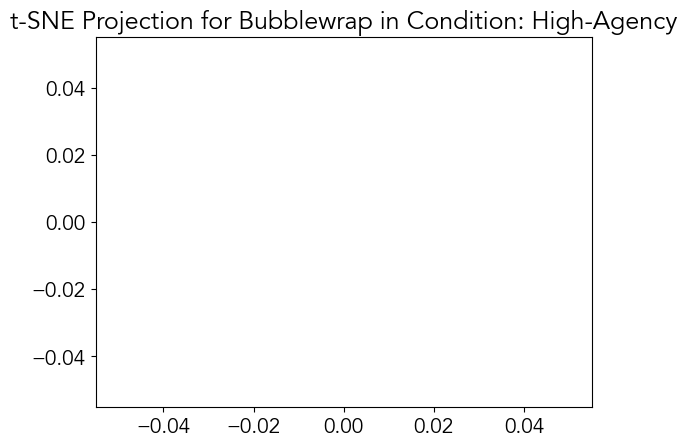

In [152]:
# Filter to bubblewrap and plot t-SNE for each condition

for condition in unique_conditions:
    bubblewrap_mask = (df['object'] == 'bubblewrap') & (df['condition'] == condition)
    data = all_embeddings[bubblewrap_mask]
    plot_kwds = {'s': 50, 'alpha': 0.7}
    projection = sklearn.manifold.TSNE().fit_transform(data)

    # Color the points by their cluster labels to visually inspect the clustering quality
    colors = df.loc[bubblewrap_mask, 'raw_cluster_label'].values
    plt.scatter(projection[:, 0], projection[:, 1], c=colors, cmap='tab10', **plot_kwds)
    plt.title(f't-SNE Projection for Bubblewrap in Condition: {condition}')
    plt.show()



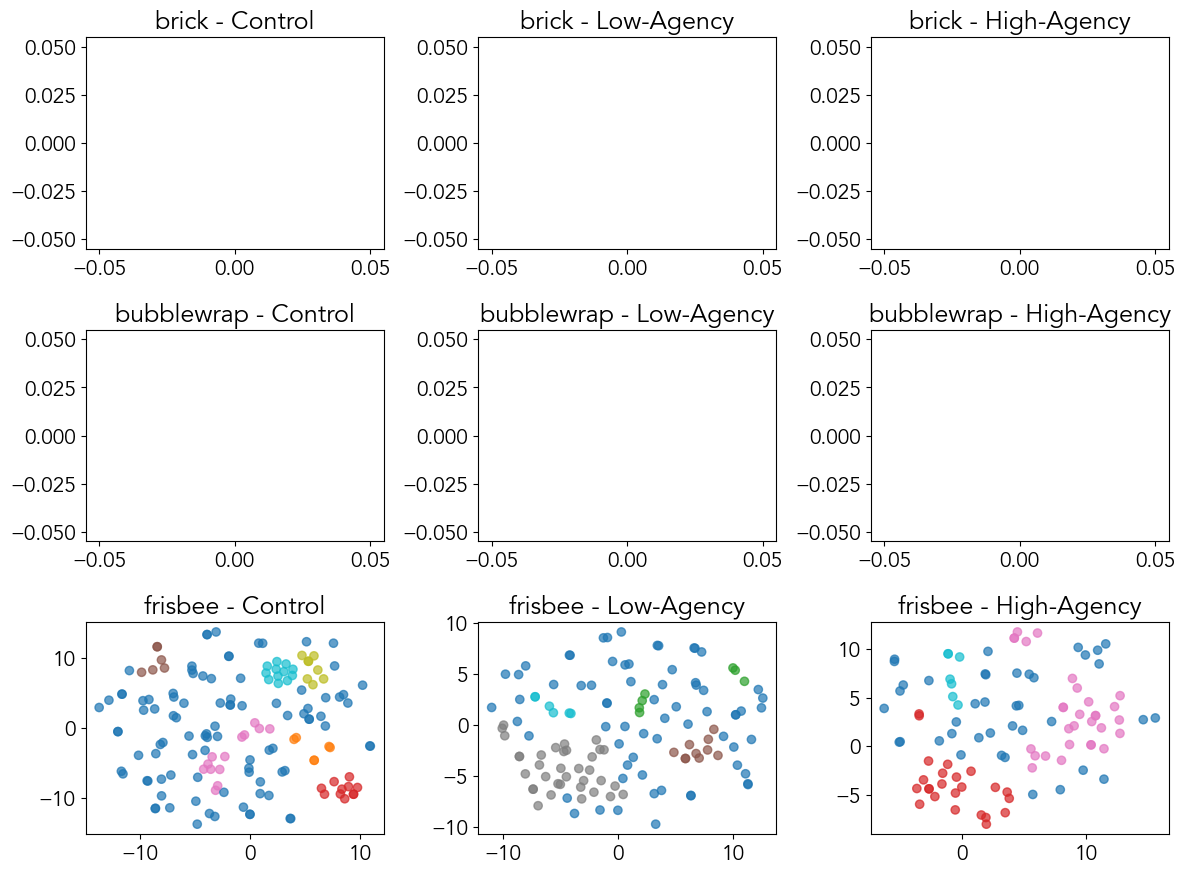

In [153]:
# Repeat for all object-condition pairs and display the results in a grid of t-SNE plots


n_objects = len(unique_objects)
n_conditions = len(unique_conditions)

# Create a grid of subplots
fig, axes = plt.subplots(n_objects, n_conditions, figsize=(4*n_conditions, 3*n_objects), squeeze=False)

# For each object-condition pair, plot t-SNE
for i, obj in enumerate(unique_objects):
    for j, condition in enumerate(unique_conditions):
        obj_cond_mask = (df['object'] == obj) & (df['condition'] == condition)
        if obj_cond_mask.sum() < 2:  # Skip if less than 2 samples
            axes[i][j].set_title(f"{obj} - {condition}")
            axes[i][j].text(0.5, 0.5, "Not enough samples", ha='center', va='center', transform=axes[i][j].transAxes)
            continue

        data = all_embeddings[obj_cond_mask]
        projection = sklearn.manifold.TSNE().fit_transform(data)

        # Color the points by their cluster labels to visually inspect the clustering quality
        colors = df.loc[obj_cond_mask, 'raw_cluster_label'].values
        axes[i][j].scatter(projection[:, 0], projection[:, 1], c=colors, cmap='tab10', alpha=0.7)
        axes[i][j].set_title(f"{obj} - {condition}")

plt.tight_layout()
plt.show()

In [154]:
# Calculate number of unique clusters and noise ratio for each combination of object and condition
# There should be nine rows in total (3 objects x 3 conditions)

cluster_stats = []

for condition in unique_conditions:
    for obj in unique_objects:
        obj_cond_mask = (df['object'] == obj) & (df['condition'] == condition)
        
        unique_clusters = df.loc[obj_cond_mask, 'raw_cluster_label'].nunique()
        noise_ratio = (df.loc[obj_cond_mask, 'raw_cluster_label'] == -1).mean()
        
        cluster_stats.append({
            'Object': obj,
            'Condition': condition,
            'Unique_Clusters': unique_clusters,
            'Noise_Ratio': noise_ratio
        })

    

# Display Results
results_df = pd.DataFrame(cluster_stats)

print(results_df.sort_values(by=['Object', 'Unique_Clusters'], ascending=[True, False]))



       Object    Condition  Unique_Clusters  Noise_Ratio
0       brick      Control                0     0.000000
3       brick   Low-Agency                0     0.000000
6       brick  High-Agency                0     0.000000
1  bubblewrap      Control                0     0.000000
4  bubblewrap   Low-Agency                0     0.000000
7  bubblewrap  High-Agency                0     0.000000
2     frisbee      Control                7     0.631579
5     frisbee   Low-Agency                5     0.536000
8     frisbee  High-Agency                4     0.396040


In [155]:

# Extract the most representative idea for each cluster
representative_ideas = []

# For each combination of object and condition, find the most representative idea for each cluster

for cond in unique_conditions:
    for obj in unique_objects:
        obj_cond_mask = (df['object'] == obj) & (df['condition'] == cond)
        if obj_cond_mask.sum() < 2:  # Skip if less than 2 samples
            continue
        for cluster_id in df[obj_cond_mask]['raw_cluster_label'].unique():
            # Get all ideas in this specific cluster for this object
            mask = obj_cond_mask & (df['raw_cluster_label'] == cluster_id)
            cluster_subset = df[mask]
        
        if len(cluster_subset) > 0:
            # The idea with the lowest distance to the group centroid is the "Medoid"
            # (Using a simple approximation here)
            cluster_vectors = all_embeddings[mask]
            centroid = cluster_vectors.mean(axis=0)
            distances = cosine_distances(cluster_vectors, centroid.reshape(1, -1)).flatten()
            best_idx = np.argmin(distances)
            best_representative = cluster_subset.iloc[best_idx]['use']
            
            # See which conditions contributed to this cluster
            contributors = cluster_subset['condition'].unique().tolist()
            
            representative_ideas.append({
                'Object': obj,
                'Cluster_ID': cluster_id,
                'Exemplar': best_representative,
                'Conditions_Present': contributors
            })

rep_df = pd.DataFrame(representative_ideas)
print("\n--- Representative Ideas per Cluster ---")
print(rep_df)

## Heatmap


  


--- Representative Ideas per Cluster ---
    Object  Cluster_ID               Exemplar Conditions_Present
0  frisbee         2.0       fetch with a dog          [Control]
1  frisbee         3.0  To play with your pet       [Low-Agency]
2  frisbee         2.0               sunshade      [High-Agency]


In [156]:
    # Replace cluster IDs with Exemplars for readability
    # Filter rep_df to only include clusters for this object
    obj_rep_df = rep_df[rep_df['Object'] == obj]
    cluster_to_exemplar = dict(zip(obj_rep_df['Cluster_ID'], obj_rep_df['Exemplar']))
    # Filter out noise points (cluster_id == -1)
    obj_data = obj_data[obj_data.index != -1]
    obj_data.index = [cluster_to_exemplar[i] for i in obj_data.index]
    
    # Create a list of truncated exemplar names for better visualization
    truncated_brick_exemplars = ["weight", "doorstop", "rustic bookend"]
    truncated_bubble_exemplars = ["cushion", "DIY stress relief", "bubble wrap art"]
    truncated_frisbee_exemplars = ["decoration", "makeshift plate", "frisbee art", "hat"]

    # Replace exemplar names with truncated versions, following the order in rep_df
    if obj == 'brick':
        obj_data.index = truncated_brick_exemplars
    elif obj == 'bubble':
        obj_data.index = truncated_bubble_exemplars
    elif obj == 'frisbee':
        obj_data.index = truncated_frisbee_exemplars

    sns.heatmap(obj_data, annot=True, cmap="YlGnBu", fmt=".2%")
    plt.title(f"Semantic Fingerprint: {obj}")
    plt.xlabel("")
    plt.ylabel("Idea Category (Cluster)")
    # Make all y-axis labels horizontal for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"figures/heatmap_{obj}.png")

  # Entropy

  # 1. Filter out noise (-1) so we only look at categorized ideas
valid_df = df[df['raw_cluster_label'] != -1]

entropy_results = []

for obj in unique_objects:
    for cond in unique_conditions:
        # Get the distribution of cluster labels for this specific group
        group_mask = (valid_df['object'] == obj) & (valid_df['condition'] == cond)
        cluster_counts = valid_df[group_mask]['raw_cluster_label'].value_counts()
        
        # Calculate Shannon Entropy
        # This measures the 'unpredictability' of which cluster an idea falls into
        group_entropy = entropy(cluster_counts)
        
        entropy_results.append({
            'Object': obj,
            'Condition': cond,
            'Entropy': group_entropy,
            'Unique_Clusters': len(cluster_counts)
        })

# 2. Display the results
entropy_df = pd.DataFrame(entropy_results)
print(entropy_df.pivot(index='Object', columns='Condition', values='Entropy'))

IndentationError: unexpected indent (2762132211.py, line 3)